# Data augmentation example

- Use a little sample of MNIST to generate a model with good performance.


In [1]:
from __future__ import print_function

#Basic libraries
import numpy as np
import tensorflow as tf
print('Tensorflow version: ', tf.__version__)
import time

#Show images
import matplotlib.pyplot as plt
%matplotlib inline
# plt configuration
plt.rcParams['figure.figsize'] = (10, 10)        # size of images
plt.rcParams['image.interpolation'] = 'nearest'  # show exact image
plt.rcParams['image.cmap'] = 'gray'  # use grayscale 

# Select GPU
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"


Tensorflow version:  1.4.0


In [2]:
# Import mnist dataset and rescale between [0,1]
from tensorflow.contrib.keras import datasets

(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data(path='mnist.npz')

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.
X_test /= 255.

print('X train shape: ',X_train.shape)
print('y train shape: ',y_train.shape)
print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)

X train shape:  (60000, 28, 28)
y train shape:  (60000,)
X test shape:  (10000, 28, 28)
y test shape:  (10000,)


In [3]:
# Reshape (the input format is vector)
X_train = np.reshape(X_train, (len(X_train),28,28,1))
X_test  = np.reshape(X_test,  (len(X_test) ,28,28,1))
print('X train shape: ',X_train.shape)
print('X test shape: ', X_test.shape)


X train shape:  (60000, 28, 28, 1)
X test shape:  (10000, 28, 28, 1)


In [4]:
#Select a random subsample of the train data for each class
def create_sample(x, y,  sample_size=100):

    class_list = np.unique(y_train)

    sample_ix = []
    for i in class_list:
        class_ix = np.where(y==i)[0]
        class_ix_sample  = np.random.choice(class_ix, sample_size)
        sample_ix += list(class_ix_sample)
    
    #Shuffle sample
    sample_ix = np.random.permutation(sample_ix)

    return x[sample_ix], y[sample_ix]

#Create new sample datasets
X_train_sample, y_train_sample = create_sample(X_train, y_train, sample_size=100)
print('X train sample shape: ',X_train_sample.shape)
print('y train sample shape: ',y_train_sample.shape)



X train sample shape:  (1000, 28, 28, 1)
y train sample shape:  (1000,)


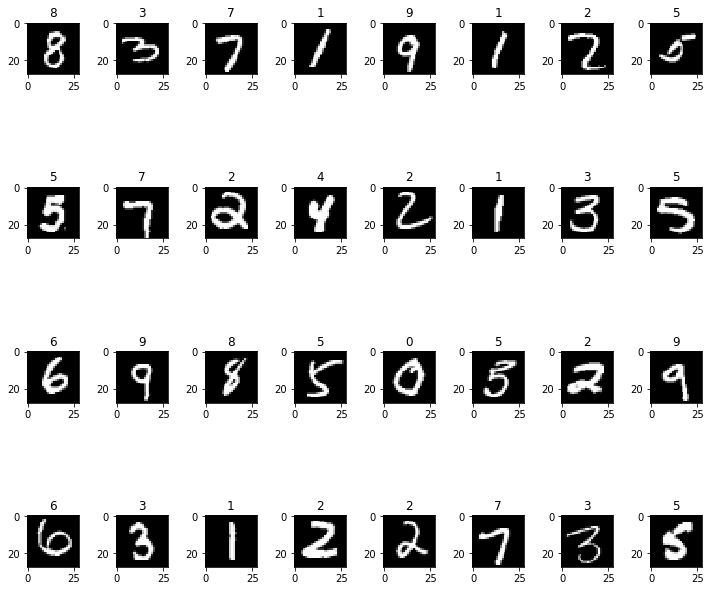

In [5]:
#Examine the data
fig = plt.figure()
for n, i in enumerate(range(32)): 
    a = fig.add_subplot(4,8,n+1)
    a.set_title(str(y_train_sample[i]))
    fig.tight_layout()
    plt.imshow(np.reshape(X_train_sample[i],(28,28)))
    


In [6]:
#Define the architecture
from tensorflow.contrib.keras import models, layers, optimizers, callbacks, preprocessing


print('Creating Lenet architecture.')

#Inputs
images = layers.Input(batch_shape=(None, 28, 28, 1), dtype='float32', name='Images')

#First convolutional layer
conv1 = layers.Conv2D(20, (5,5))(images)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

#Second convolutional layer
conv2 = layers.Conv2D(20, (5,5))(pool1)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

#Flatten convolution output
flat = layers.Flatten(name='Flat_image')(pool2)

# First dense layer
dense1 = layers.Dense(500, activation='relu', name='Dense_1')(flat)

# Second dense layer
output = layers.Dense(10, activation='softmax', name='Dense_output')(dense1)



Creating Lenet architecture.


In [7]:
# Configure input and output data for the Model
model_conv = models.Model(inputs=images, outputs=output)
model_conv.summary()


# Select optimizer and compile model
sgd_optimizer = optimizers.SGD(lr=0.01, momentum=0.99, decay=0.005, nesterov=True)
model_conv.compile(loss='sparse_categorical_crossentropy', 
                   optimizer=sgd_optimizer, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Images (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 20)        520       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 20)          10020     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 20)          0         
_________________________________________________________________
Flat_image (Flatten)         (None, 320)               0         
_________________________________________________________________
Dense_1 (Dense)              (None, 500)               160500    
__________

In [8]:
#Fit the model
batch_size = 64
epochs = 30

# Tensorflow callback
tb_callback_ln = callbacks.TensorBoard(log_dir='/tmp/tensorboard/mnist/conv_aug1')

history_conv = model_conv.fit(X_train_sample, y_train_sample, batch_size=batch_size, epochs=epochs,
                              validation_data=(X_test, y_test), callbacks=[tb_callback_ln])


Train on 1000 samples, validate on 10000 samples
Epoch 1/30
1000/1000 [==============================] - 1s - loss: 2.2182 - acc: 0.3200 - val_loss: 1.9625 - val_acc: 0.6616
Epoch 2/30
1000/1000 [==============================] - 0s - loss: 1.2014 - acc: 0.7290 - val_loss: 0.6855 - val_acc: 0.7749
Epoch 3/30
1000/1000 [==============================] - 0s - loss: 0.6383 - acc: 0.8420 - val_loss: 0.8387 - val_acc: 0.8664
Epoch 4/30
1000/1000 [==============================] - 0s - loss: 0.6607 - acc: 0.8750 - val_loss: 0.7245 - val_acc: 0.8679
Epoch 5/30
1000/1000 [==============================] - 0s - loss: 0.3535 - acc: 0.9160 - val_loss: 0.7090 - val_acc: 0.8940
Epoch 6/30
1000/1000 [==============================] - 0s - loss: 0.2502 - acc: 0.9630 - val_loss: 0.7528 - val_acc: 0.9038
Epoch 7/30
1000/1000 [==============================] - 0s - loss: 0.2081 - acc: 0.9630 - val_loss: 0.8520 - val_acc: 0.9031
Epoch 8/30
1000/1000 [==============================] - 0s - loss: 0.1445 - 

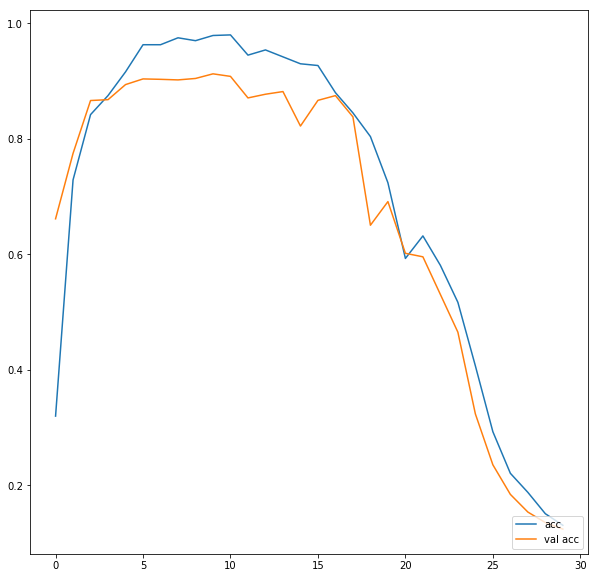

In [9]:
plt.plot(history_conv.history['acc'], label='acc')
plt.plot(history_conv.history['val_acc'], label='val acc')
plt.legend(loc='lower right')
plt.show()

## Data augmentation model

In [10]:
print('Second model. The same Lenet architecture')

#Inputs
images = layers.Input(batch_shape=(None, 28, 28, 1), dtype='float32', name='Images')

#First convolutional layer
conv1 = layers.Conv2D(20, (5,5))(images)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

#Second convolutional layer
conv2 = layers.Conv2D(20, (5,5))(pool1)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

#Flatten convolution output
flat = layers.Flatten(name='Flat_image')(pool2)

# First dense layer
dense1 = layers.Dense(500, activation='relu', name='Dense_1')(flat)

# Second dense layer
output = layers.Dense(10, activation='softmax', name='Dense_output')(dense1)



Second model. The same Lenet architecture


In [11]:
# Define inputs - outputs
model_aug = models.Model(inputs=images, outputs=output)
model_aug.summary()


# Select optimizer and compile model
sgd_optimizer = optimizers.SGD(lr=0.01, momentum=0.99, decay=0.005, nesterov=True)
model_aug.compile(loss='sparse_categorical_crossentropy', 
                   optimizer=sgd_optimizer, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Images (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 20)        520       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 20)          10020     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 20)          0         
_________________________________________________________________
Flat_image (Flatten)         (None, 320)               0         
_________________________________________________________________
Dense_1 (Dense)              (None, 500)               160500    
__________

In [12]:
# Augmentation for training
train_datagen = preprocessing.image.ImageDataGenerator(
    #rotation_range=0.25,
    width_shift_range=0.2,
    height_shift_range=0.12,
    shear_range=0.3,
    zoom_range=[0.9,1.3])



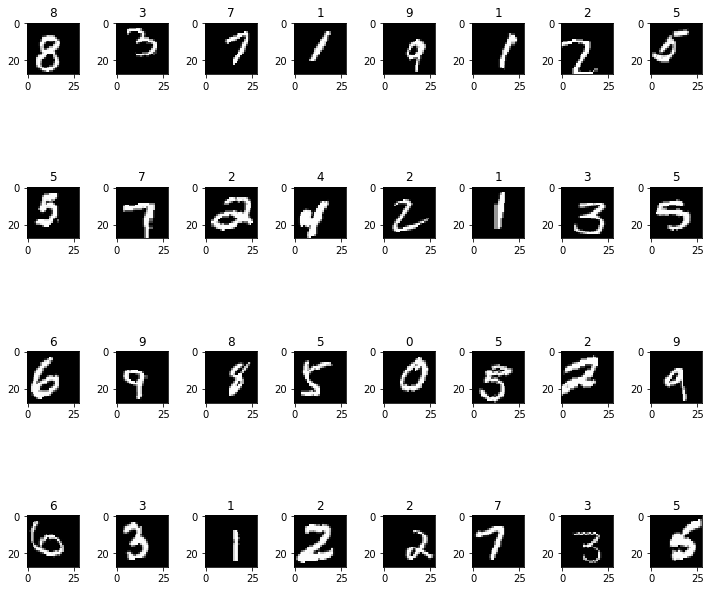

In [13]:
#Visualize the ugmented images
fig = plt.figure()
for n, i in enumerate(range(32)): 
    a = fig.add_subplot(4,8,n+1)
    a.set_title(str(y_train_sample[i]))
    fig.tight_layout()
    plt.imshow(np.reshape(train_datagen.random_transform(X_train_sample[i]),(28,28)))
    
    


In [14]:
batch_size = 64
epochs = 30
tb_callback_ln = callbacks.TensorBoard(log_dir='/tmp/tensorboard/mnist/conv_aug2')
history_aug = model_aug.fit_generator(train_datagen.flow(X_train_sample, y_train_sample, batch_size=batch_size),
                                      steps_per_epoch=len(X_train) // batch_size,
                                      epochs=epochs,
                                      validation_data=(X_test, y_test),
                                      callbacks=[tb_callback_ln])


Epoch 1/30
937/937 [==============================] - 11s - loss: 0.4568 - acc: 0.8559 - val_loss: 0.1398 - val_acc: 0.9671
Epoch 2/30
937/937 [==============================] - 11s - loss: 0.0948 - acc: 0.9712 - val_loss: 0.1246 - val_acc: 0.9732
Epoch 3/30
937/937 [==============================] - 11s - loss: 0.0514 - acc: 0.9846 - val_loss: 0.1164 - val_acc: 0.9725
Epoch 4/30
937/937 [==============================] - 11s - loss: 0.0301 - acc: 0.9906 - val_loss: 0.1139 - val_acc: 0.9745
Epoch 5/30
937/937 [==============================] - 11s - loss: 0.0224 - acc: 0.9936 - val_loss: 0.1075 - val_acc: 0.9751
Epoch 6/30
937/937 [==============================] - 11s - loss: 0.0207 - acc: 0.9937 - val_loss: 0.1091 - val_acc: 0.9764
Epoch 7/30
937/937 [==============================] - 12s - loss: 0.0172 - acc: 0.9952 - val_loss: 0.1035 - val_acc: 0.9768
Epoch 8/30
937/937 [==============================] - 11s - loss: 0.0159 - acc: 0.9953 - val_loss: 0.1038 - val_acc: 0.9774
Epoch 9/

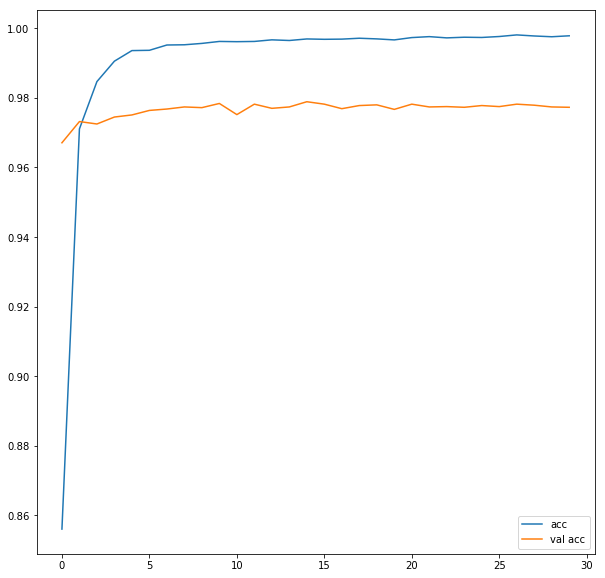

In [15]:
# Plot history
plt.plot(history_aug.history['acc'], label='acc')
plt.plot(history_aug.history['val_acc'], label='val acc')
plt.legend(loc='lower right')
plt.show()

# Improve data augmentation
    - Create a generator function adding new transformations

In [16]:
print('Model 3. The same Lenet architecture')

#Inputs
images = layers.Input(batch_shape=(None, 28, 28, 1), dtype='float32', name='Images')

#First convolutional layer
conv1 = layers.Conv2D(20, (5,5))(images)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

#Second convolutional layer
conv2 = layers.Conv2D(20, (5,5))(pool1)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

#Flatten convolution output
flat = layers.Flatten(name='Flat_image')(pool2)

# First dense layer
dense1 = layers.Dense(500, activation='relu', name='Dense_1')(flat)

# Second dense layer
output = layers.Dense(10, activation='softmax', name='Dense_output')(dense1)



Model 3. The same Lenet architecture


In [17]:
# Model Architecture defined
model_aug2 = models.Model(inputs=images, outputs=output)
model_aug2.summary()


# Select optimizer and compile model
sgd_optimizer = optimizers.SGD(lr=0.01, momentum=0.99, decay=0.005, nesterov=True)
model_aug2.compile(loss='sparse_categorical_crossentropy', 
                   optimizer=sgd_optimizer, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Images (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 20)        520       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 20)          10020     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 20)          0         
_________________________________________________________________
Flat_image (Flatten)         (None, 320)               0         
_________________________________________________________________
Dense_1 (Dense)              (None, 500)               160500    
__________

In [18]:
# Augmentation for training
train_datagen = preprocessing.image.ImageDataGenerator(
    rotation_range=0.25,
    width_shift_range=0.2,
    height_shift_range=0.12,
    shear_range=0.3,
    zoom_range=[0.9,1.3])

In [19]:
def img_augmented(img):
    import random
    import cv2
    #Erode - dilate
    if random.random() < 0.7:
        img = cv2.erode(img, np.ones(2, np.uint8), iterations=1)
    elif random.random() < 0.7:
        img = cv2.dilate(img, np.ones(2, np.uint8), iterations=1)
    return img


def data_generator(x, y, batch_size=32):
    for x_batch, y_batch in train_datagen.flow(x, y, batch_size=batch_size):
        x_batch_transform=[]
        for img in x_batch:
            x_batch_transform += [np.reshape(img_augmented(img),(28,28,1))]
        yield np.array(x_batch_transform), y_batch


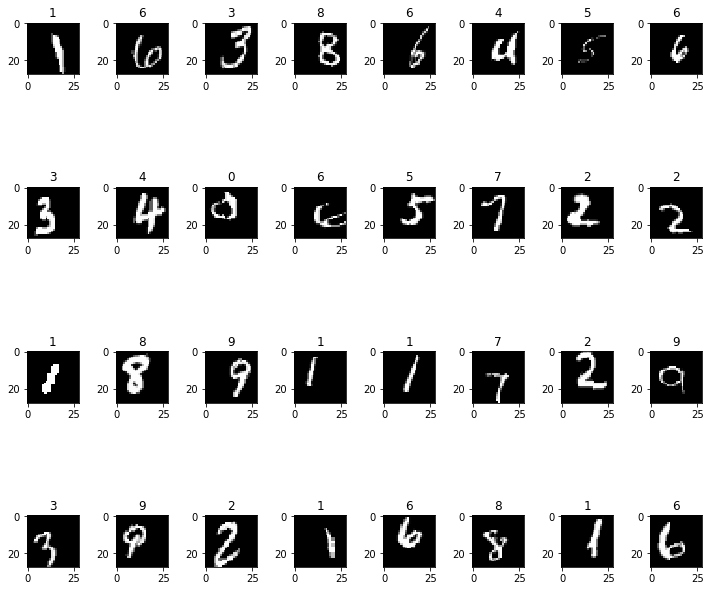

In [20]:
#Visualize data augmentation
dg = data_generator(X_train_sample, y_train_sample, batch_size=32)
x_sample, y_sample = next(dg)


#Examine the data
fig = plt.figure()
for n, i in enumerate(range(32)): 
    a = fig.add_subplot(4,8,n+1)
    a.set_title(str(y_sample[i]))
    fig.tight_layout()
    plt.imshow(np.reshape(x_sample[i],(28,28)))


In [21]:
batch_size = 64
epochs = 30
tb_callback_ln = callbacks.TensorBoard(log_dir='/tmp/tensorboard/mnist/conv_aug2')
history_aug2 = model_aug2.fit_generator(data_generator(X_train_sample, y_train_sample, batch_size=batch_size),
                                       steps_per_epoch=len(X_train) // batch_size,
                                       epochs=epochs,
                                       validation_data=(X_test, y_test),
                                       callbacks=[tb_callback_ln])


Epoch 1/30
937/937 [==============================] - 14s - loss: 0.5013 - acc: 0.8374 - val_loss: 0.1262 - val_acc: 0.9629
Epoch 2/30
937/937 [==============================] - 13s - loss: 0.1112 - acc: 0.9646 - val_loss: 0.1052 - val_acc: 0.9727
Epoch 3/30
937/937 [==============================] - 13s - loss: 0.0636 - acc: 0.9797 - val_loss: 0.0885 - val_acc: 0.9771
Epoch 4/30
937/937 [==============================] - 13s - loss: 0.0504 - acc: 0.9837 - val_loss: 0.0846 - val_acc: 0.9792
Epoch 5/30
937/937 [==============================] - 13s - loss: 0.0425 - acc: 0.9860 - val_loss: 0.0853 - val_acc: 0.9783
Epoch 6/30
937/937 [==============================] - 13s - loss: 0.0352 - acc: 0.9889 - val_loss: 0.0861 - val_acc: 0.9797
Epoch 7/30
937/937 [==============================] - 13s - loss: 0.0316 - acc: 0.9895 - val_loss: 0.0850 - val_acc: 0.9807
Epoch 8/30
937/937 [==============================] - 13s - loss: 0.0312 - acc: 0.9902 - val_loss: 0.0872 - val_acc: 0.9799
Epoch 9/

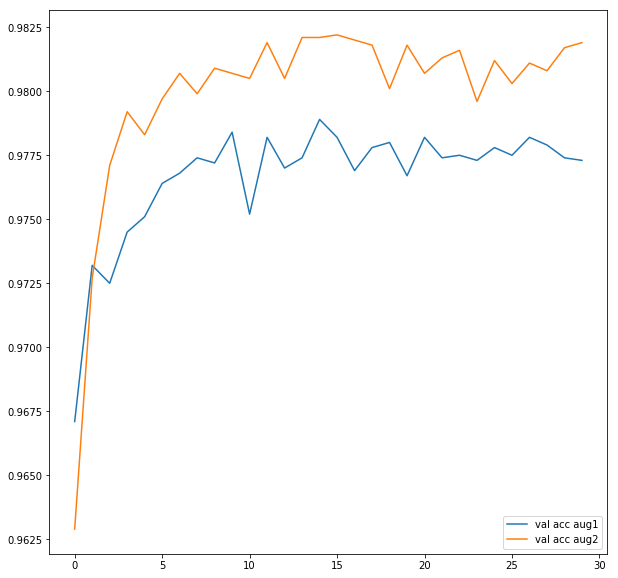

In [22]:
# Compare test
plt.plot(history_aug.history['val_acc'] , label='val acc aug1')
plt.plot(history_aug2.history['val_acc'], label='val acc aug2')
plt.legend(loc='lower right')
plt.show()